## Change point detection of COVID-19 cases using Bayesian modelling
Using a Bayesian model for estimating the date that the distribution of new COVID-19 cases in a particular country changes

### Timeline of COVID-19 Pandemic in UK 
- **16th March** - Prime Minister Boris Johnson advised everyone in the UK against "non-essential" travel and contact with others, as well as suggesting people should avoid pubs, clubs and theatres, and work from home if possible. 
- **23rd March** - Boris Johnson announced in a television broadcast that measures to mitigate the virus were to be tightened further in order to protect the NHS, with wide-ranging restrictions made on freedom of movement, enforceable in law for a "stay at home" period which would last for at least three weeks.
- **27 March and afterwards** - include additional cases from tests carried out on key workers.




### References
* [Wikipedia: Timeline of the COVID-19 pandemic in the United Kingdom](https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_the_United_Kingdom)
* [Wikipedia: COVID-19 pandemic in the United Kingdom](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_Kingdom)
* [Inferring change points in the spread of COVID-19 reveals the effectiveness of interventions](https://science.sciencemag.org/content/early/2020/05/14/science.abb9789)
* [Probabilistic programming in Python: Pyro versus PyMC3](https://tomasfiers.net/posts/probabilistic-python/)
* [SVI Part I: An Introduction to Stochastic Variational Inference in Pyro](http://pyro.ai/examples/svi_part_i.html)
* [Understanding Pyro’s Model and Guide: A Love Story](https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886)
* [PyMC3 + PyTorch](https://dfm.io/posts/pymc-pytorch/)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.1, color_codes=True)
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression

from scipy import stats
import statsmodels.api as sm
import pylab

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 100  # fig size

In [2]:
data = pd.read_csv("./data/covid_19_clean_20200519.csv")
data.Date = pd.to_datetime(data.Date)

# use only canada for now
cad = data.loc[data["Country/Region"] == "Canada", ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
cad.columns = ["country", "date", "confirmed", "deaths", "recovered"]

# group by country and date, sum(confirmed, deaths, recovered)
cad = cad.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

# convert date string to datetime
cad.date = pd.to_datetime(cad.date)
cad = cad.sort_values(by = "date")
cad.tail()

,country,date,confirmed,deaths,recovered
114,Canada,2020-05-15,75959,5679,0
115,Canada,2020-05-16,77206,5800,0
116,Canada,2020-05-17,78332,5903,0
117,Canada,2020-05-18,79411,5960,0
118,Canada,2020-05-19,80493,6028,0


In [3]:
# countries with the most cases:
data.loc[data["Date"] == "2020-05-18", ["Country/Region", "Confirmed"]].sort_values(by = "Confirmed", 
                                                                                    ascending = False)[:7]

,Country/Region,Confirmed
31230,US,1508308
31192,Russia,290678
31033,Brazil,255368
31228,United Kingdom,246406
31206,Spain,231606
31142,Italy,225886
31121,France,177554


In [5]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country(country, end_date, state = False) : 
    if state :
        df = data.loc[data["Province/State"] == country, ["Province/State", "Date", "Confirmed", "Deaths", "Recovered"]]
    else : 
        df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
    df.columns = ["country", "date", "confirmed", "deaths", "recovered"]

    # group by country and date, sum(confirmed, deaths, recovered). do this because countries have multiple cities 
    df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

    # convert date string to datetime
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by = "date")
    df = df[df.date <= end_date]

    # TODO check if the selected date range is intact

    # make new confirmed cases every day:
    cases_shifted = np.array([0] + list(df.confirmed[:-1]))
    daily_confirmed = np.array(df.confirmed) - cases_shifted
    df["daily_confirmed"] = daily_confirmed 
    
    # moving average for daily confirmed cases
    df["moving_avg"] = df.daily_confirmed.rolling(window=4).mean()

    return df

#
def plot_lines(df, savefig=False):

    country = df['country'].to_list()[0]

    fig, ax = plt.subplots(2,1, figsize=(12, 10), sharex=True)
    # accummulated cases
    sns.lineplot(x="date", 
                 y="confirmed", 
                 data= df,
                 ax = ax[0]
                ).set_title("Total Confirmed COVID-19 Cases in %s" % country)
    ax[0].set(ylabel='Confirmed Cases (accummulated)', xlabel='')

    # daily confirmed cases, along with moving average
    sns.lineplot(x = df.date, 
                 y = df.daily_confirmed, 
                #  label = "Raw Data",
                 ax = ax[1])
    ax[1].set(ylabel='Confirmed Cases (daily)', 
              xlabel='',
              title = "Daily New Confirmed COVID-19 Cases in %s" % country)

    # # moving average of daily cases
    # sns.lineplot(x = df.date, 
    #              y = df.moving_avg, 
    #              label = "Moving Average",
    #              legend = "full",
    #              ax = ax[2]).set_title("Daily New Confirmed COVID-19 Cases in %s" % country)

    # set x ticks
    dt_ticks = df['date'].to_list()[::14]
    dt_ticklabels = [i.strftime('%d/%m') for i in dt_ticks]
    for i in range(ax.shape[0]):
        ax[i].set_xticks(dt_ticks) # set sparse xticks
        ax[i].set_xticklabels(dt_ticklabels)

    ax[-1].set_xlabel("Date", labelpad=10)  # set xlabel
    # plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=30, horizontalalignment='right')  # rotate x ticks
    
    plt.tight_layout()

    # save the figure
    if savefig==True:
        plt.savefig('./plots/cases-uk.svg', dpi=300, bbox_inches='tight')
    
    plt.show()

    return fig, ax


#
def plot_twin_axis(df, savefig=False):

    country = df['country'].to_list()[0]
    palette = sns.color_palette("bright", 2)
    sns.set(context='notebook', style='ticks', rc={'lines.linewidth':2}, palette='deep', font='sans-serif', font_scale=1.2, color_codes=True)

    fig, ax = plt.subplots(1,1, figsize=(12, 5))
    
    # accummulated cases
    sns.lineplot(x="date", 
                 y="confirmed", 
                 data= df,
                 label = 'accumulated',
                 color = palette[0],
                 legend=None,  # disable single legend
                 ax = ax)
    # ax.set_title("Confirmed COVID-19 Cases in %s" % country, y=1.02)
    ax.set_xlabel("Date", labelpad=10)  # set xlabel
    ax.set_ylabel(r'Accummulated confirmed cases', labelpad=10)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    # create double y axis
    ax2 = plt.twinx()
    
    # daily confirmed cases, along with moving average
    sns.lineplot(x = df.date, 
                 y = df.daily_confirmed, 
                 label = "daily",
                 color = palette[1],
                 legend=None,  # disable single legend
                 ax = ax2)
    ax2.set_ylabel(r'Daily confirmed cases', labelpad=10)
    # ax2.set(ylabel='Confirmed Cases (daily)', xlabel='')
    ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    # legend
    ax.figure.legend(loc='upper left', bbox_to_anchor=(0.11,0.92), ncol=1)
    
    # set x ticks
    dt_ticks = df['date'].to_list()[::14]
    dt_ticklabels = [i.strftime('%d/%m') for i in dt_ticks]
    ax.set_xticks(dt_ticks) # set sparse xticks
    ax.set_xticklabels(dt_ticklabels)

    # plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=30, horizontalalignment='right')  # rotate x ticks
    
    plt.tight_layout()

    # save the figure
    if savefig==True:
        plt.savefig('./plots/confirmed-cases-uk.svg', dpi=300, bbox_inches='tight')
    
    plt.show()

    return fig, ax

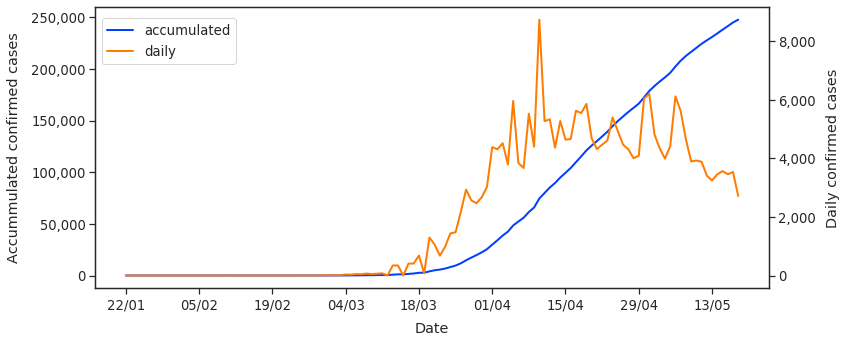

In [6]:
df_uk = create_country("United Kingdom", end_date = "2020-05-18")  # UK
df_us = create_country("US", end_date = "2020-05-18")  # US

df_ca = create_country("Canada", end_date = "2020-04-30")  # Canada

df_it = create_country("Italy", end_date = "2020-05-18")  # Italy
df_es = create_country("Spain", end_date = "2020-05-18")  # Spain
df_de = create_country("Germany", end_date = "2020-05-18")  # Germany
df_cn = create_country("China", end_date = "2020-05-18")  # China

# plot_lines(df_uk, savefig=True)
plot_twin_axis(df_uk, savefig=True)
# plot_lines(df_us)
# plot_lines(df_ca)
# plot_lines(df_cn)
pass

### Check if the date range of the data is intact

In [6]:
#
date_rng = pd.date_range(start='20200122', end='20200518', freq='D', name='date')
print(date_rng[0], date_rng[-1], len(date_rng))

# UK 
print(df_uk.loc[0, 'date'], df_uk.loc[df_uk.index[-1], 'date'], df_uk['date'].shape[0])

2020-01-22 00:00:00 2020-05-18 00:00:00 118
2020-01-22 00:00:00 2020-05-18 00:00:00 118


In [7]:
# data filtering

# UK
uk_start = "2020-03-03" # 51 confirmed
df_uk = df_uk[df_uk.date >= uk_start].reset_index(drop = True)
df_uk["days_since_start"] = np.arange(df_uk.shape[0]) + 1
df_uk_tmp = df_uk[df_uk.date < '2020-04-30']

# US
us_start = "2020-02-26" # 57 confirmed cases
df_us = df_us[df_us.date >= us_start].reset_index(drop = True)
df_us["days_since_start"] = np.arange(df_us.shape[0]) + 1

# Canada
ca_start = "2020-02-27" # 13 confirmed cases
df_ca = df_ca[df_ca.date >= ca_start].reset_index(drop = True)
df_ca["days_since_start"] = np.arange(df_ca.shape[0]) + 1
# print(df_ca.shape)

df_ca_tmp = df_ca[df_ca.date < '2020-03-28']
# print(df_ca_tmp.shape)

######################################################################
# variable for data to easily swap it out:

# country_ = "Canada (Before March 28th)"
# reg_data = df_ca_tmp.copy()

country_ = "UK"
reg_data = df_uk_tmp.copy()
#####################################################################

In [8]:
# df_uk.head()
print(reg_data.shape)
reg_data.head(12)

(58, 8)


,country,date,confirmed,deaths,recovered,daily_confirmed,moving_avg,days_since_start
0,United Kingdom,2020-03-03,51,0,8,11,7.75,1
1,United Kingdom,2020-03-04,86,0,8,35,15.75,2
2,United Kingdom,2020-03-05,116,0,8,30,20.00,3
3,United Kingdom,2020-03-06,164,1,8,48,31.00,4
4,United Kingdom,2020-03-07,207,2,18,43,39.00,5
5,United Kingdom,2020-03-08,274,2,18,67,47.00,6
6,United Kingdom,2020-03-09,322,3,18,48,51.50,7
7,United Kingdom,2020-03-10,384,7,19,62,55.00,8
8,United Kingdom,2020-03-11,459,7,19,75,63.00,9
9,United Kingdom,2020-03-12,459,9,19,0,46.25,10


### Inconsistencies in the data
In UK there are no new confirmed cases on March 12th, but nearly double the expected cases on March 13th. In cases like this, the data was split between the two days.

In [9]:
reg_data.loc[reg_data.date=='2020-03-12', 'daily_confirmed'] = 171
reg_data.loc[reg_data.date=='2020-03-13', 'daily_confirmed'] = 172

reg_data.head(12)

,country,date,confirmed,deaths,recovered,daily_confirmed,moving_avg,days_since_start
0,United Kingdom,2020-03-03,51,0,8,11,7.75,1
1,United Kingdom,2020-03-04,86,0,8,35,15.75,2
2,United Kingdom,2020-03-05,116,0,8,30,20.00,3
3,United Kingdom,2020-03-06,164,1,8,48,31.00,4
4,United Kingdom,2020-03-07,207,2,18,43,39.00,5
5,United Kingdom,2020-03-08,274,2,18,67,47.00,6
6,United Kingdom,2020-03-09,322,3,18,48,51.50,7
7,United Kingdom,2020-03-10,384,7,19,62,55.00,8
8,United Kingdom,2020-03-11,459,7,19,75,63.00,9
9,United Kingdom,2020-03-12,459,9,19,171,46.25,10


### Examine the NaNs

In [10]:
print(reg_data.info())
# print('Null values:{}'.format(reg_data.isna().sum()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country           58 non-null     object        
 1   date              58 non-null     datetime64[ns]
 2   confirmed         58 non-null     int64         
 3   deaths            58 non-null     int64         
 4   recovered         58 non-null     int64         
 5   daily_confirmed   58 non-null     int64         
 6   moving_avg        58 non-null     float64       
 7   days_since_start  58 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 4.1+ KB
None


### Proof of Concept (testing out piecewise regression to see if its reasonnable)

(41, 1)
Regression 1 weight:  0.16
Regression 1 bias:  3.11
Regression 2 weight:  -0.01
Regression 2 bias:  8.99


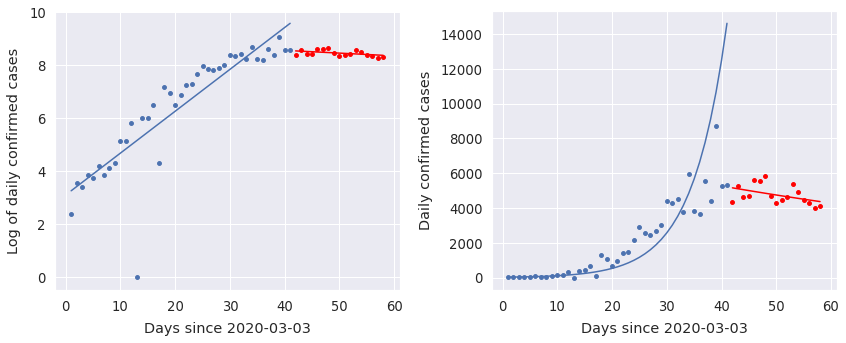

In [11]:
# just choose a random point to split on. difference here is that we have a closed form solution
_date = 42

# piece 1
df = reg_data[reg_data.days_since_start < _date]
x = np.array(df["days_since_start"]).reshape(-1, 1) # predictor is the day number, t
print(x.shape)

# # check histogram of daily confirmed cases to see if is skewed
# df_tmp = df.copy()
# df_tmp['log_daily_confirmed'] = df_tmp['daily_confirmed'].apply(lambda x: np.log(x))
# df_tmp.hist(['daily_confirmed', 'log_daily_confirmed'], figsize=(10,5))

y = np.log(np.array(df["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg = LinearRegression()
_ = reg.fit(x, y)
print("Regression 1 weight: ", round(reg.coef_[0][0], 2))
print("Regression 1 bias: ", round(reg.intercept_[0], 2))

# piece 2
df2 = reg_data[reg_data.days_since_start >= _date]
x2 = np.array(df2["days_since_start"]).reshape(-1, 1) # predictor is the day number, t
y2 = np.log(np.array(df2["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg2 = LinearRegression()
_ = reg2.fit(x2, y2)
print("Regression 2 weight: ", round(reg2.coef_[0][0], 2))
print("Regression 2 bias: ", round(reg2.intercept_[0], 2))

# plot data:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# log regression model
ax[0].scatter(x, y, s = 15)
ax[0].scatter(x2, y2, s = 15, color = "red")
ax[0].plot(x, x*reg.coef_[0][0] + reg.intercept_) 
ax[0].plot(x2, x2*reg2.coef_[0][0] + reg2.intercept_, color = "red") 
ax[0].set_ylabel("Log of daily confirmed cases", labelpad=8)
ax[0].set_xlabel("Days since %s" % uk_start, labelpad=8)
# ax[0].text(1, 9, 'Log Data')

ax[1].scatter(x, np.exp(y), s = 15)
ax[1].scatter(x2, np.exp(y2), s = 15, color = "red")
ax[1].plot(x, np.exp(x*reg.coef_[0][0] + reg.intercept_))
ax[1].plot(x2, np.exp(x2*reg2.coef_[0][0] + reg2.intercept_), color = "red")
ax[1].set_ylabel("Daily confirmed cases", labelpad=8)
ax[1].set_xlabel("Days since %s" % uk_start, labelpad=8)
# ax[1].set(title = "Daily Cases: Piecewise Regression Model - Original Data")
# ax[1].text(1, 12000, 'Original Data')

# fig.suptitle(f"{country_} Daily Cases: Piecewise Regression Model", y=1.02)

plt.tight_layout()
plt.savefig('./plots/piecewise-lg-uk.svg', dpi=300, bbox_inches='tight')
plt.show()

## Change point estimation using Pyro

In [12]:
import pickle
import torch
import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample

from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

#
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

# we should be able to have an empirical estimate for the mean of the prior for the 2nd regression bias term
# this will be something like b = log(max(daily_confirmed))

# might be able to have 1 regression model but change the data so that we have new terms for (tau < t) 
# like an interaction term

class COVID_change(PyroModule):
    def __init__(self, in_features, out_features, b1_mu, b2_mu):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear1.weight = PyroSample(dist.Normal(0.5, 0.25).expand([1, 1]).to_event(1))
        self.linear1.bias = PyroSample(dist.Normal(b1_mu, 1.))
        
        # could possibly have stronger priors for the 2nd regression line, because we wont have as much data
        self.linear2 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear2.weight = PyroSample(dist.Normal(0., 0.25).expand([1, 1])) #.to_event(1))
        self.linear2.bias = PyroSample(dist.Normal(b2_mu, b2_mu/4))

    def forward(self, x, y=None):
        tau = pyro.sample("tau", dist.Beta(4, 3))
        sigma = pyro.sample("sigma", dist.Uniform(0., 3.))
        # fit lm's to data based on tau
        sep = int(np.ceil(tau.detach().numpy() * len(x)))
        mean1 = self.linear1(x[:sep]).squeeze(-1)
        mean2 = self.linear2(x[sep:]).squeeze(-1)
        mean = torch.cat((mean1, mean2))
        obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [13]:
# TODO to be deleted
aa = PyroSample(dist.Normal(0.5, 0.25).expand([1,1]))
bb = PyroSample(dist.Normal(0.5, 0.25))
print(type(aa))
print(aa)

print(type(bb))
print(bb)

tau = pyro.sample("tau", dist.Beta(4, 3))

print(type(tau))
print(tau)

<class 'pyro.nn.module.PyroSample'>
PyroSample(prior=Normal(loc: tensor([[0.5000]]), scale: tensor([[0.2500]])))
<class 'pyro.nn.module.PyroSample'>
PyroSample(prior=Normal(loc: 0.5, scale: 0.25))
<class 'torch.Tensor'>
tensor(0.5618)


In [14]:
tensor_data = torch.tensor(reg_data[["daily_confirmed", "days_since_start"]].values, dtype=torch.float)
x_data = tensor_data[:, 1].unsqueeze_(1)
y_data = np.log(tensor_data[:, 0])

print(type(x_data))
print(type(y_data))
# prior hyper params
# take log of the average of the 1st quartile to get the prior mean for the bias of the 2nd regression line
q1 = np.quantile(y_data, q = 0.25)
bias_1_mean = np.mean(y_data.numpy()[y_data <= q1])
print("Prior mean for Bias 1: ", bias_1_mean)

# take log of the average of the 4th quartile to get the prior mean for the bias of the 2nd regression line
q4 = np.quantile(y_data, q = 0.75)
bias_2_mean = np.mean(y_data.numpy()[y_data >= q4])
print("Prior mean for Bias 2: ", bias_2_mean)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Prior mean for Bias 1:  3.9961164
Prior mean for Bias 2:  8.594


## There are generally two approaches to approximate inference:

- Sampling
- Variational inference

In sampling, you use an algorithm (called a Monte Carlo method) that draws samples from the probability distribution that you are performing inference on – or at least from a good approximation to it. You then perform your desired inference calculation on the samples. For example: mode of the probability distribution? –> Just find the most common sample. One class of sampling methods are the Markov Chain Monte Carlo (MCMC) methods, of which Hamiltonian/Hybrid Monte Carlo (HMC) and No-U-Turn Sampling (NUTS) are refinements.

Variational inference (VI) is an approach to approximate inference that does not need samples. It transforms the inference problem into an optimisation problem, where we need to maximise some target function.

### Method 1: Approximate Inference with Stochastic Variational Inference (SVI)

In [15]:
model = COVID_change(1, 1, b1_mu = bias_1_mean, b2_mu = bias_2_mean)

# TODO check further
auto_guide = AutoDiagonalNormal(model)

svi = SVI(model = model, # bayesian regression class
          guide = auto_guide, # using auto guide
          optim = pyro.optim.Adam({"lr": 0.1}), # optimizer
          loss=Trace_ELBO()) # loss function

num_iterations = 7500

# param_store is where pyro stores param estimates
pyro.clear_param_store()

# inference loop
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 750 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(y_data)))
        
auto_guide.requires_grad_(False)
num_samples = 2000
predictive = Predictive(model = model, 
                        guide = auto_guide, 
                        num_samples = num_samples,
                        return_sites=("linear1.weight", "linear1.bias", 
                                      "linear2.weight", "linear2.bias", 
                                      "tau", "sigma", "_RETURN", "obs"))
samples = predictive(x_data)

##############################################################
# save samples
##############################################################
# loc1 = "./data/samples_svi.pkl"
# with open(loc1, 'wb') as f:
#     pickle.dump(samples, f)

##############################################################
# load samples
##############################################################  
# samples = pickle.load(open(loc1, "rb"))


pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma

predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_daily_confirmed": y_data,
})
predictions.head()

[iteration 0001] loss: 14.3807
[iteration 0751] loss: 1.8505
[iteration 1501] loss: 1.9372
[iteration 2251] loss: 1.5044
[iteration 3001] loss: 2.1551
[iteration 3751] loss: 1.6163
[iteration 4501] loss: 1.6657
[iteration 5251] loss: 3.2257
[iteration 6001] loss: 2.0511
[iteration 6751] loss: 2.0795


,days_since_start,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_daily_confirmed
0,1.0,3.209275,2.763932,3.648565,3.298138,0.677014,5.782740,2.397895
1,2.0,3.311985,2.868716,3.760379,3.357310,0.701609,5.963109,3.555348
2,3.0,3.414695,2.969661,3.876870,3.416186,0.872704,5.893569,3.401197
3,4.0,3.517407,3.054262,3.990369,3.498328,0.916394,6.088526,3.871201
4,5.0,3.620114,3.133742,4.112968,3.644433,1.032575,6.294003,3.761200


In [16]:
# TODO to be deleted
print(samples['linear1.weight'])
print(samples['linear1.bias'].size())
print(samples['_RETURN'].size())

tensor([[[0.1188]],

        [[0.0877]],

        [[0.1098]],

        ...,

        [[0.0980]],

        [[0.1305]],

        [[0.0888]]])
torch.Size([2000])
torch.Size([2000, 58])


### Method 2: Hamiltonian Monte Carlo (HMC) with No-U-Turn Sampler (NUTS)

In [19]:
model = COVID_change(1, 1, b1_mu = bias_1_mean, b2_mu = bias_2_mean)

# need more than 400 samples/chain if we want to use a flat prior on b_2 and w_2
num_samples =800 
# mcmc 
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 
            num_samples=num_samples,
            warmup_steps = 150, 
            num_chains = 4)
mcmc.run(x_data, y_data)
samples = mcmc.get_samples()


Sample [1]: 100%|█████████▉| 948/950 [46:30,  3.49s/it, step size=4.82e-03, acc. prob=0.696]


Sample [4]:  97%|█████████▋| 922/950 [46:31,  3.70s/it, step size=6.43e-03, acc. prob=0.770]

Sample [1]: 100%|█████████▉| 949/950 [46:34,  3.52s/it, step size=4.82e-03, acc. prob=0.696]

Sample [3]:  95%|█████████▍| 900/950 [46:35,  3.36s/it, step size=3.15e-03, acc. prob=0.743]


Sample [1]: 100%|██████████| 950/950 [46:38,  3.58s/it, step size=4.82e-03, acc. prob=0.696]

Sample [3]:  95%|█████████▍| 901/950 [46:39,  3.39s/it, step size=3.15e-03, acc. prob=0.744]


Sample [2]:  88%|████████▊ | 835/950 [46:39,  3.62s/it, step size=1.01e-03, acc. prob=0.882]


Sample [4]:  97%|█████████▋| 925/950 [46:41,  3.38s/it, step size=6.43e-03, acc. prob=0.769]

Sample [2]:  88%|████████▊ | 836/950 [46:43,  3.48s/it, step size=1.01e-03, acc. prob=0.882]


Sample [4]:  97%|█████████▋| 926/950 [46:45,  3.30s/it, step size=6.43e-03, acc. prob=0.769]

Sample [2]:  88%|████████▊ | 837/950 [46:46,  3.45s/it,

TypeError: Pickling an AuthenticationString object is disallowed for security reasons

In [17]:
# https://forum.pyro.ai/t/save-mcmc-results/428/8

# Uncomment to save mcmc object
# mcmc.sampler = None

import dill
loc2 = "./data/samples_mcmc.pkl"

# with open(loc2, 'wb') as f:
#     dill.dump([mcmc, samples], f)
    
# load samples
[mcmc, samples] = dill.load(open(loc2, "rb"))

In [18]:
# TODO to be deleted

tau_post = samples["tau"].detach().numpy()
print(type(tau_post))

qq = np.ceil(tau_post * len(x_data))
print(type(qq))
print(qq.shape)
tau_days = list(map(int, np.ceil(tau_post * len(x_data))))
print(len(tau_days))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3200,)
3200


In [19]:
# extract individual posteriors
weight_1_post = samples["linear1.weight"].detach().numpy()
weight_2_post = samples["linear2.weight"].detach().numpy()
bias_1_post = samples["linear1.bias"].detach().numpy()
bias_2_post = samples["linear2.bias"].detach().numpy()
tau_post = samples["tau"].detach().numpy()
sigma_post = samples["sigma"].detach().numpy()

# build likelihood distribution:
tau_days = list(map(int, np.ceil(tau_post * len(x_data))))
mean_ = torch.zeros(len(tau_days), len(x_data))
obs_ = torch.zeros(len(tau_days), len(x_data))
for i in range(len(tau_days)) : 
    mean_[i, :] = torch.cat((x_data[:tau_days[i]] * weight_1_post[i] + bias_1_post[i],
                          x_data[tau_days[i]:] * weight_2_post[i] + bias_2_post[i])).reshape(len(x_data))
    obs_[i, :] = dist.Normal(mean_[i, :], sigma_post[i]).sample()
samples["_RETURN"] = mean_
samples["obs"] = obs_

pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma

predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_daily_confirmed": y_data,
})

w1_ = pred_summary["linear1.weight"]
w2_ = pred_summary["linear2.weight"]

b1_ = pred_summary["linear1.bias"]
b2_ = pred_summary["linear2.bias"]

tau_ = pred_summary["tau"]
sigma_ = pred_summary["sigma"]

# Compute the date when the change happens
ind = int(np.ceil(tau_["mean"] * len(x_data)))
print('tau = {}, number of data points: {}'.format(tau_["mean"], len(x_data)))
predictions.head()

tau = 0.487549751996994, number of data points: 58


,days_since_start,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_daily_confirmed
0,1.0,2.963950,2.479629,3.430027,2.959424,1.491445,4.443442,2.397895
1,2.0,3.150943,2.696553,3.589568,3.143867,1.765442,4.552732,3.555348
2,3.0,3.337940,2.907142,3.751758,3.355000,1.897829,4.855102,3.401197
3,4.0,3.524928,3.119576,3.914679,3.522276,2.082041,4.989905,3.871201
4,5.0,3.711917,3.331145,4.082222,3.707853,2.241021,5.134086,3.761200


## Model Diagnostics
When assessing the convergence for MCMC, there are 3 metrics can be used, ie., observing mixing, observing stationarity of the chains, and  $\hat{R}$ factor.
$\hat{R}$ is the factor by which each posterior distribution will reduce by as the number of samples tends to infinity. A perfect $\hat{R}$ value is 1, and values less than $\textbf{1.1}$ are indicative of convergence. We observe mixing and stationarity of the Markov chains in order to know if the HMC is producing appropriate posterior samples.

In [20]:
mcmc.summary()
diag = mcmc.diagnostics()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                tau      0.49      0.08      0.50      0.36      0.61    175.75      1.02
              sigma      0.84      0.08      0.83      0.71      0.97    631.58      1.01
linear1.weight[0,0]      0.19      0.02      0.19      0.15      0.22    311.91      1.00
       linear1.bias      2.78      0.31      2.79      2.28      3.28    348.78      1.01
linear2.weight[0,0]      0.00      0.02      0.00     -0.03      0.03     86.09      1.06
       linear2.bias      8.46      0.93      8.42      6.89      9.82     84.21      1.06

Number of divergences: 0


[Text(0.5, 1.0, 'Sigma, R_hat: 1.008262')]

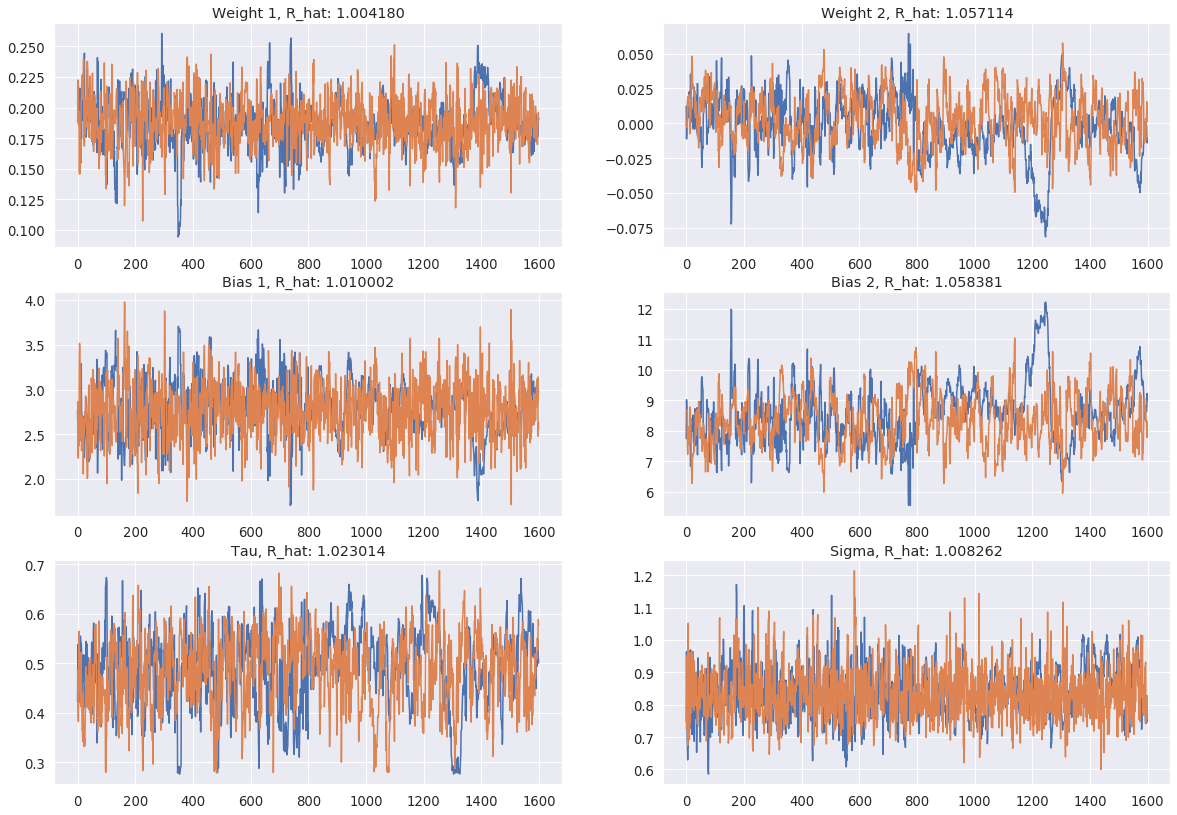

In [21]:
n_samples = np.arange(len(weight_1_post))
_half = int(len(n_samples) / 2)
fig, ax = plt.subplots(3,2, figsize=(20, 14))

ax[0,0].plot(n_samples[:_half], weight_1_post[:_half, 0])
ax[0,0].plot(n_samples[:_half], weight_1_post[_half:, 0])
ax[0,0].set(title="Weight 1, R_hat: %f" % diag["linear1.weight"]['r_hat'].numpy())

#ax[0,1].plot(n_samples, weight_2_post[:, 0]);
ax[0,1].plot(n_samples[:_half], weight_2_post[:_half, 0])
ax[0,1].plot(n_samples[:_half], weight_2_post[_half:, 0])
ax[0,1].set(title="Weight 2, R_hat: %f" % diag["linear2.weight"]['r_hat'].numpy())

ax[1,0].plot(n_samples[:_half], bias_1_post[:_half])
ax[1,0].plot(n_samples[:_half], bias_1_post[_half:])
ax[1,0].set(title="Bias 1, R_hat: %f" % diag["linear1.bias"]['r_hat'].numpy())

ax[1,1].plot(n_samples[:_half], bias_2_post[:_half])
ax[1,1].plot(n_samples[:_half], bias_2_post[_half:])
ax[1,1].set(title="Bias 2, R_hat: %f" % diag["linear2.bias"]['r_hat'].numpy())

ax[2,0].plot(n_samples[:_half], tau_post[:_half])
ax[2,0].plot(n_samples[:_half], tau_post[_half:])
ax[2,0].set(title="Tau, R_hat: %f" % diag["tau"]['r_hat'].numpy())

ax[2,1].plot(n_samples[:_half], sigma_post[:_half])
ax[2,1].plot(n_samples[:_half], sigma_post[_half:])
ax[2,1].set(title="Sigma, R_hat: %f" % diag["sigma"]['r_hat'].numpy())

## Posterior Plots

29
2020-04-01 00:00:00


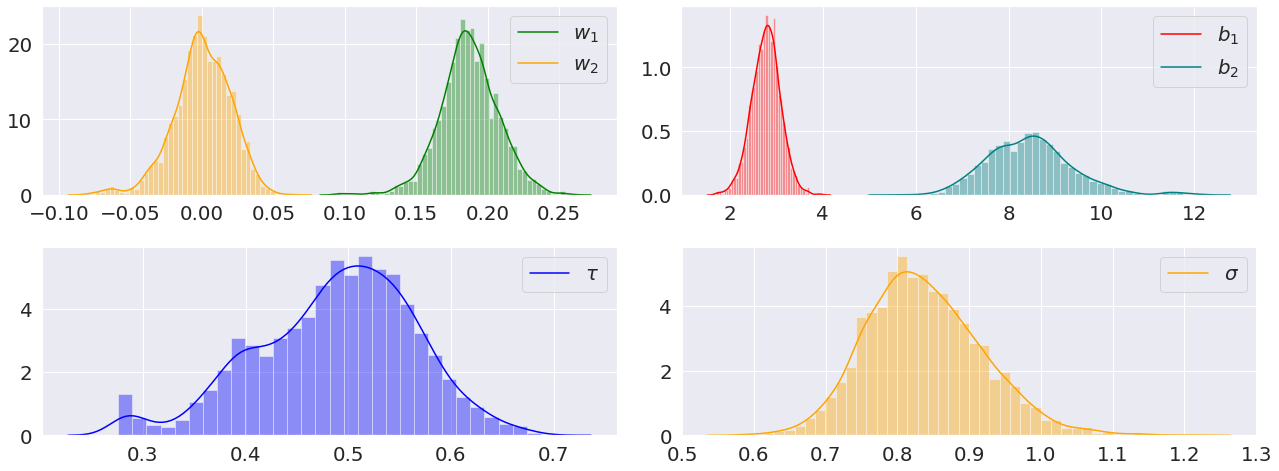

In [22]:
print(ind)
print(reg_data.date[ind])

# plot data:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.8, color_codes=True)
fig, ax = plt.subplots(2,2, figsize=(18, 7))
# plt.suptitle("Posterior Distributions for %s" % country_, fontsize=15, y=1.02)

sns.distplot(weight_1_post, 
             kde_kws = {"label": r"$w_1$"}, 
             color = "green",
             norm_hist = True,
             kde = True,
             ax = ax[0, 0])
#ax[0, 0].axvline(x = w1_["mean"], linestyle = '--')

sns.distplot(weight_2_post, 
             kde_kws = {"label": r"$w_2$"}, 
             color = "orange",
             norm_hist = True,
             kde = True,
             ax = ax[0, 0])
#ax[0, 0].axvline(x = w2_["mean"], linestyle = '--')

sns.distplot(bias_1_post, 
             kde_kws = {"label": r"$b_1$"}, 
             color = "red",
             norm_hist = True,
             kde = True,
             ax = ax[0, 1])
#ax[0, 1].axvline(x = b1_["mean"], linestyle = '--')

sns.distplot(bias_2_post, 
             kde_kws = {"label": r"$b_2$"}, 
             color = "teal",
             norm_hist = True,
             kde = True,
             ax = ax[0, 1])
#ax[0, 1].axvline(x = b2_["mean"], linestyle = '--');

sns.distplot(tau_post, 
             kde_kws = {"label": r"$\tau$"}, 
             color = "blue",
             norm_hist = True,
             kde = True,
             ax = ax[1, 0])
# ax[1, 0].axvline(x = tau_["mean"], linestyle = '--', color = "red")
# ax[1, 0].axvline(x = np.median(tau_post), linestyle = '--', color = "blue")

sns.distplot(sigma_post, 
             kde_kws = {"label": r"$\sigma$"}, 
             color = "orange",
             norm_hist = True,
             kde = True,
             ax = ax[1,1])
#ax[1, 1].axvline(x = sigma_["mean"], linestyle = '--')
plt.tight_layout()
# save the figure
plt.savefig('./plots/posterior-dist-uk.svg', dpi=300, bbox_inches='tight')
plt.show()

Date of change for UK: 2020-04-01


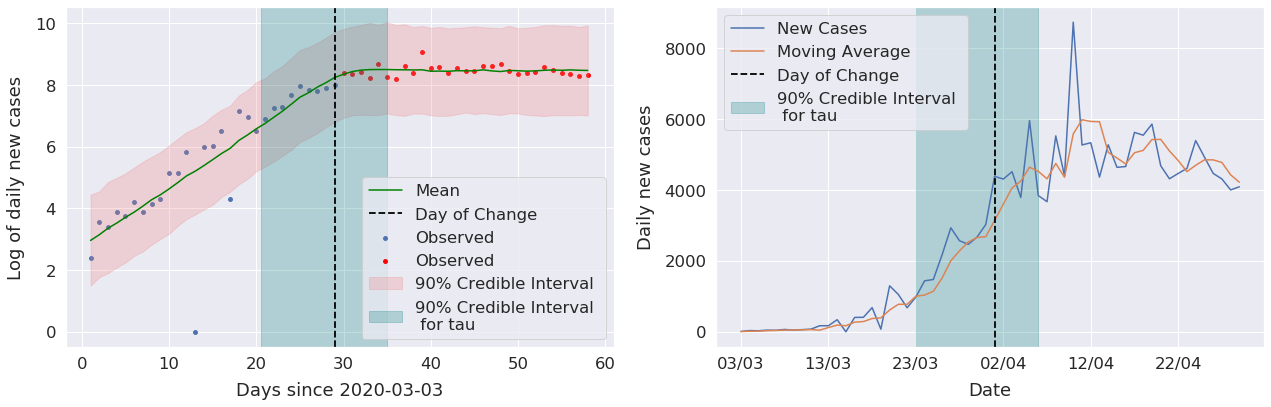

In [23]:
start_date_ = str(reg_data.date[0]).split(' ')[0]
change_date_ = str(reg_data.date[ind]).split(' ')[0]
print("Date of change for {}: {}".format(country_, change_date_))

# plot data:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# plt.suptitle("Daily New Cases in %s" % country_, fontsize=15, y=1.02)

# log regression model
ax[0].scatter(y = y_data[:ind], x = x_data[:ind], s = 15, label= 'Observed')
ax[0].scatter(y = y_data[ind:], x = x_data[ind:], s = 15, color = "red", label= 'Observed')

ax[0].plot(predictions["days_since_start"],
           predictions["y_mean"], 
           color = "green",
           label = "Mean") 
ax[0].axvline(ind, 
              linestyle = '--', linewidth = 1.8,
              label = "Day of Change",
              color = "black")
ax[0].fill_between(predictions["days_since_start"], 
                   predictions["y_perc_5"], 
                   predictions["y_perc_95"], 
                   alpha = 0.25,
                   label = "90% Credible Interval",
                   color = "lightcoral")
ax[0].fill_betweenx([0, 1], 
                    tau_["5%"] * len(x_data), 
                    tau_["95%"] * len(x_data), 
                    alpha = 0.25,
                    label = "90% Credible Interval \n for tau",
                    color = "teal",
                    transform=ax[0].get_xaxis_transform())
# ax[0].set(ylabel = "Log of daily new cases", 
#           xlabel = "Days since %s" % start_date_, 
#         #   title = "Log Daily New Cases in %s" % country_
#           )
ax[0].set_xlabel("Days since %s" % start_date_, labelpad=10)
ax[0].set_ylabel("Log of daily new cases", labelpad=10)

ax[0].legend(loc = "bottom right")


# plot daily confirmed cases, along with moving average
sns.lineplot(x = "date", 
             y = "daily_confirmed", 
             data = reg_data,
             label = "New Cases",
             ax = ax[1])
sns.lineplot(x = "date", 
             y = "moving_avg", 
             data = reg_data,
             label = "Moving Average",
             ax = ax[1])

ax[1].fill_betweenx([0, 1], 
                    reg_data.date[int(tau_["5%"] * len(x_data))], 
                    reg_data.date[int(tau_["95%"] * len(x_data))], 
                    alpha = 0.25,
                    label = "90% Credible Interval \n for tau",
                    color = "teal",
                    transform=ax[1].get_xaxis_transform())
ax[1].axvline(reg_data.date[ind], 
              linestyle = '--', linewidth = 1.8,
              label = "Day of Change", 
              color = "black")

plt.xticks(reg_data.date.to_list()[::10])
dt_ticklabels = [i.strftime('%d/%m') for i in reg_data.date.to_list()[::10]]
ax[1].set_xticklabels(dt_ticklabels)

# ax[1].xaxis.set_major_locator(plt.MaxNLocator(6)) # reduce number of xticks

ax[1].set_xlabel("Date", labelpad=10)
ax[1].set_ylabel("Daily new cases", labelpad=10)

# ax[1].set(ylabel = "Daily new cases", xlabel = "Date")

ax[1].legend()

plt.tight_layout()

# save the figure
plt.savefig('./plots/change-point-uk.svg', dpi=300, bbox_inches='tight')
plt.show()

[Text(0.5, 1.0, 'QQ Plot of Residuals - UK')]

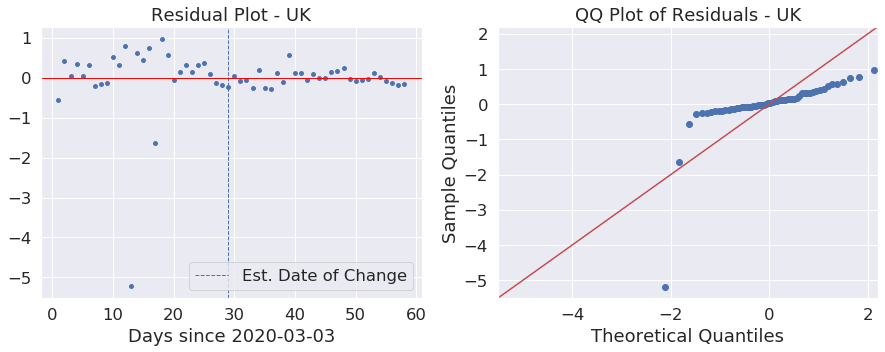

In [24]:
# residual and qq plot
resid = predictions["true_daily_confirmed"] - predictions["y_mean"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].scatter(predictions["days_since_start"], 
              resid,
              s = 15)
ax[0].axvline(ind, linestyle = '--', 
              linewidth = 1, label = "Est. Date of Change")
ax[0].axhline(0, linewidth = 1,
              color = "red")
ax[0].legend()
ax[0].set(title="Residual Plot - %s" % country_,
          xlabel = "Days since %s" % start_date_)

sm.qqplot(resid, line='45', ax = ax[1])
ax[1].set(title = "QQ Plot of Residuals - %s" % country_)

**Date of change for UK: 2020-04-01**

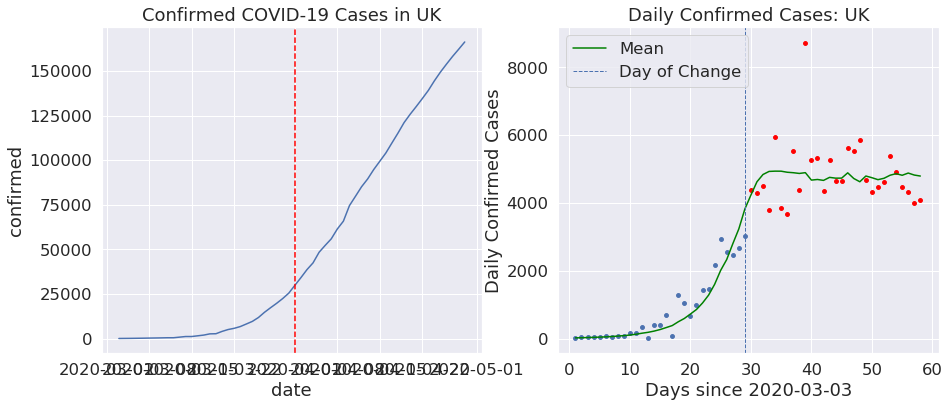

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= reg_data,
             ax = ax[0]
            ).set_title("Confirmed COVID-19 Cases in %s" % country_)
ax[0].axvline(reg_data.date[ind], color="red", linestyle="--")

ax[1].scatter(y = reg_data.daily_confirmed[:ind], x = x_data[:ind], s = 15)
ax[1].scatter(y = reg_data.daily_confirmed[ind:], x = x_data[ind:], s = 15, color = "red")

ax[1].plot(predictions["days_since_start"],
           np.exp(predictions["y_mean"]), 
           color = "green",
           label = "Mean") 
# ax[1].fill_between(predictions["days_since_start"], 
#                    np.exp(predictions["y_perc_5"]), 
#                    np.exp(predictions["y_perc_95"]), 
#                    alpha = 0.25,
#                    label = "90% Credible Interval",
#                    color = "teal");
ax[1].axvline(ind, linestyle = '--', 
              linewidth = 1,
              label = "Day of Change")
ax[1].legend(loc = "upper left")
ax[1].set(ylabel = "Daily Confirmed Cases", 
          xlabel = "Days since %s" % start_date_,
          title = "Daily Confirmed Cases: %s" % country_)
printmd("**Date of change for {}: {}**".format(country_, change_date_))